<a href="https://colab.research.google.com/github/Durba01/Transfer-Learning/blob/Transfer_learning/transfer_learning_3_scaling_up.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**06. Transfer Learning with TensorFlow Part 3: Scaling up (🍔👁 Food Vision mini)**

In [ ]:
# what GPU are we on
!nvidia-smi

Sat Jan 29 05:05:31 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 495.46       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   33C    P0    27W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
# get helper functions file 
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py

--2022-01-29 05:05:31--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0s      

2022-01-29 05:05:31 (106 MB/s) - ‘helper_functions.py’ saved [10246/10246]



In [ ]:
# import helper functions
from helper_functions import create_tensorboard_callback, plot_loss_curves, unzip_data, compare_historys, walk_through_dir

In [ ]:
# Download the food101 data 
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/101_food_classes_10_percent.zip 


--2022-01-29 05:05:33--  https://storage.googleapis.com/ztm_tf_course/food_vision/101_food_classes_10_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 142.250.145.128, 173.194.79.128, 108.177.119.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.250.145.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1625420029 (1.5G) [application/zip]
Saving to: ‘101_food_classes_10_percent.zip’

101_food_classes_10 100%[===================>]   1.51G   103MB/s    in 16s     

2022-01-29 05:05:50 (96.0 MB/s) - ‘101_food_classes_10_percent.zip’ saved [1625420029/1625420029]



In [ ]:
# unzip the data
unzip_data("101_food_classes_10_percent.zip")

In [ ]:
# walkthrough the data dir
walk_through_dir("101_food_classes_10_percent")

There are 2 directories and 0 images in '101_food_classes_10_percent'.
There are 101 directories and 0 images in '101_food_classes_10_percent/train'.
There are 0 directories and 75 images in '101_food_classes_10_percent/train/red_velvet_cake'.
There are 0 directories and 75 images in '101_food_classes_10_percent/train/risotto'.
There are 0 directories and 75 images in '101_food_classes_10_percent/train/pulled_pork_sandwich'.
There are 0 directories and 75 images in '101_food_classes_10_percent/train/beignets'.
There are 0 directories and 75 images in '101_food_classes_10_percent/train/gyoza'.
There are 0 directories and 75 images in '101_food_classes_10_percent/train/donuts'.
There are 0 directories and 75 images in '101_food_classes_10_percent/train/hamburger'.
There are 0 directories and 75 images in '101_food_classes_10_percent/train/tiramisu'.
There are 0 directories and 75 images in '101_food_classes_10_percent/train/samosa'.
There are 0 directories and 75 images in '101_food_clas

In [ ]:
# create test and training data 
train_dir = ("101_food_classes_10_percent/train")
test_dir = ("101_food_classes_10_percent/test")

In [ ]:
# create train and test data 
import tensorflow as tf 
 
IMG_SIZE= (224, 224)

train_data_all_10_percent = tf.keras.preprocessing.image_dataset_from_directory(directory=train_dir,
                                                                                image_size=IMG_SIZE,
                                                                                label_mode="categorical")

test_data = tf.keras.preprocessing.image_dataset_from_directory(directory=test_dir,
                                                                image_size = IMG_SIZE,
                                                                label_mode="categorical",
                                                                shuffle=False)

Found 7575 files belonging to 101 classes.
Found 25250 files belonging to 101 classes.


In [ ]:
# create checkpoint path to save model for later use
check_path = "101_classes_10_percent_data_model_checkpoint"
check_point_callback = tf.keras.callbacks.ModelCheckpoint(check_path,
                                                          monitor= "val_loss",
                                                          save_weights_only=True,
                                                          save_best_only=True)

In [ ]:
# DATA AUGMENTATION

# Import required modules for model creation
from tensorflow.keras.layers.experimental import preprocessing
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

# setup data augmentation
data_augmentation = Sequential([
                                preprocessing.RandomFlip("horizontal"),
                                preprocessing.RandomRotation(0.2),
                                preprocessing.RandomHeight(0.2),
                                preprocessing.RandomWidth(0.2),
                                preprocessing.RandomZoom(0.2),
                                #preprocessing.Rescaling(scale=1./255) For Resnest50
], name="data_augmentation")

In [ ]:
from tensorflow.python.keras.layers.core import Activation
# setup the base model and freeze the layers
base_model = tf.keras.applications.EfficientNetB0(include_top=False)
base_model.trainable = False

# create the inoput layer and pass the data augmentation to it 
inputs = layers.Input(shape=(224, 224, 3), name="input_layer")
x = data_augmentation(inputs)
x = base_model(x, training = False)
x = layers.GlobalAveragePooling2D(name="Global_avg_pooling_layer")(x)
outputs = layers.Dense(len(train_data_all_10_percent.class_names), activation="softmax", name="output_layer")(x)

16719872/16705208 [==============================] - 0s 0us/step


In [ ]:
# create a model
model = tf.keras.Model(inputs, outputs)

In [ ]:
# Let see the summary of the model we've created
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 data_augmentation (Sequenti  (None, None, None, 3)    0         
 al)                                                             
                                                                 
 efficientnetb0 (Functional)  (None, None, None, 1280)  4049571  
                                                                 
 Global_avg_pooling_layer (G  (None, 1280)             0         
 lobalAveragePooling2D)                                          
                                                                 
 output_layer (Dense)        (None, 101)               129381    
                                                                 
Total params: 4,178,952
Trainable params: 129,381
Non-trainab

In [ ]:
# compile the model
model.compile(loss="categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

In [ ]:
# fit the model
history = model.fit(train_data_all_10_percent,
                    epochs=5,
                    validation_data = test_data,
                    validation_steps=int(0.15*len(test_data)),
                    callbacks=[check_point_callback])

Epoch 1/5
237/237 [==============================] - 50s 158ms/step - loss: 3.4638 - accuracy: 0.2528 - val_loss: 2.7226 - val_accuracy: 0.3970
Epoch 2/5
237/237 [==============================] - 31s 129ms/step - loss: 2.3536 - accuracy: 0.4552 - val_loss: 2.3332 - val_accuracy: 0.4364
Epoch 3/5
237/237 [==============================] - 30s 124ms/step - loss: 1.9673 - accuracy: 0.5324 - val_loss: 2.1596 - val_accuracy: 0.4656
Epoch 4/5
237/237 [==============================] - 28s 115ms/step - loss: 1.7624 - accuracy: 0.5727 - val_loss: 2.0695 - val_accuracy: 0.4756
Epoch 5/5
237/237 [==============================] - 27s 113ms/step - loss: 1.6081 - accuracy: 0.6110 - val_loss: 2.0160 - val_accuracy: 0.4783


In [ ]:
# evaluate the model
fine_tuning_results = model.evaluate(test_data)
fine_tuning_results

790/790 [==============================] - 53s 67ms/step - loss: 1.7262 - accuracy: 0.5488


[1.7261863946914673, 0.5488317012786865]

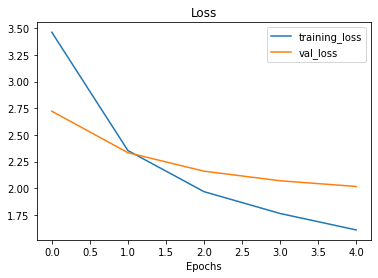

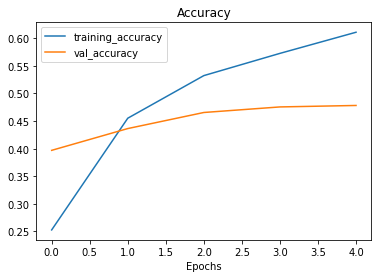

In [ ]:
# plot loss curves
plot_loss_curves(history)

**FINE TUNING**

In [ ]:
# unfreeze the layers
base_model.trainable = True

In [ ]:
# Refreeze some layers
for layer in base_model.layers[:-5]:
  layer.trainable= False

In [ ]:
# Recompile model with lower learning rate 
model.compile(loss="categorical_crossentropy",
              optimizer= tf.keras.optimizers.Adam(),
              metrics = ["accuracy"])

In [ ]:
# what layers in the model are trainabale
for layer in model.layers:
  print(layer.name, layer.trainable)

input_layer True
data_augmentation True
efficientnetb0 True
Global_avg_pooling_layer True
output_layer True


In [ ]:
for layer_number, layer in enumerate(model.layers[2].layers):
  print(layer_number, layer.name, layer.trainable)

0 input_1 False
1 rescaling False
2 normalization False
3 stem_conv_pad False
4 stem_conv False
5 stem_bn False
6 stem_activation False
7 block1a_dwconv False
8 block1a_bn False
9 block1a_activation False
10 block1a_se_squeeze False
11 block1a_se_reshape False
12 block1a_se_reduce False
13 block1a_se_expand False
14 block1a_se_excite False
15 block1a_project_conv False
16 block1a_project_bn False
17 block2a_expand_conv False
18 block2a_expand_bn False
19 block2a_expand_activation False
20 block2a_dwconv_pad False
21 block2a_dwconv False
22 block2a_bn False
23 block2a_activation False
24 block2a_se_squeeze False
25 block2a_se_reshape False
26 block2a_se_reduce False
27 block2a_se_expand False
28 block2a_se_excite False
29 block2a_project_conv False
30 block2a_project_bn False
31 block2b_expand_conv False
32 block2b_expand_bn False
33 block2b_expand_activation False
34 block2b_dwconv False
35 block2b_bn False
36 block2b_activation False
37 block2b_se_squeeze False
38 block2b_se_reshape F

In [ ]:
# Fit the model
fine_tune_epochs = 10

history_1 = model.fit(train_data_all_10_percent,
                      epochs = fine_tune_epochs,
                      validation_data = test_data,
                      validation_steps = int(0.15*len(test_data)),
                      initial_epoch = history.epoch[-1])

Epoch 5/10
237/237 [==============================] - 34s 117ms/step - loss: 1.6495 - accuracy: 0.5673 - val_loss: 2.0548 - val_accuracy: 0.4823
Epoch 6/10
237/237 [==============================] - 27s 110ms/step - loss: 1.2247 - accuracy: 0.6659 - val_loss: 1.9728 - val_accuracy: 0.4942
Epoch 7/10
237/237 [==============================] - 26s 107ms/step - loss: 0.9552 - accuracy: 0.7385 - val_loss: 2.0894 - val_accuracy: 0.4894
Epoch 8/10
237/237 [==============================] - 26s 109ms/step - loss: 0.7469 - accuracy: 0.7831 - val_loss: 2.1714 - val_accuracy: 0.4820
Epoch 9/10
237/237 [==============================] - 26s 108ms/step - loss: 0.6292 - accuracy: 0.8190 - val_loss: 2.1660 - val_accuracy: 0.4899
Epoch 10/10
237/237 [==============================] - 26s 107ms/step - loss: 0.4986 - accuracy: 0.8525 - val_loss: 2.2050 - val_accuracy: 0.5005


In [ ]:
# evaluate the result
fine_tunning_results_1 = model.evaluate(test_data)

790/790 [==============================] - 53s 67ms/step - loss: 1.9421 - accuracy: 0.5491


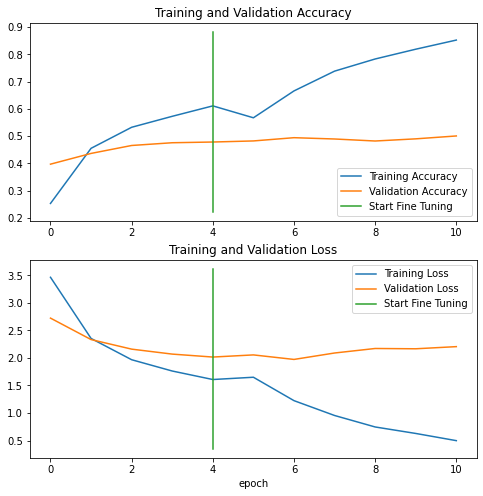

In [ ]:
# compare the two results
compare_historys(original_history=history,
                 new_history=history_1,
                 initial_epochs=5)

In [ ]:
 model.save("drive/My Drive/Colab Notebooks/101_food_class_10_percent_saved_big_dog_model")

KeyError: ignored

In [ ]:
import tensorflow as tf

# Download pre-trained model from Google Storage (like a cooking show, I trained this model earlier, so the results may be different than above)
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/06_101_food_class_10_percent_saved_big_dog_model.zip

--2022-01-29 05:24:31--  https://storage.googleapis.com/ztm_tf_course/food_vision/06_101_food_class_10_percent_saved_big_dog_model.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 142.251.18.128, 142.250.153.128, 142.250.145.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.251.18.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 46760742 (45M) [application/zip]
Saving to: ‘06_101_food_class_10_percent_saved_big_dog_model.zip’

06_101_food_class_1 100%[===================>]  44.59M   185MB/s    in 0.2s    

2022-01-29 05:24:32 (185 MB/s) - ‘06_101_food_class_10_percent_saved_big_dog_model.zip’ saved [46760742/46760742]



In [ ]:
saved_model_path = "/content/drive/MyDrive/Colab Notebooks/Transfer_Learning_3.zip"
unzip_data(saved_model_path)

FileNotFoundError: ignored

In [ ]:
model = tf.keras.models.load_model("/content/drive/MyDrive/Colab Notebooks")

OSError: ignored